In [133]:
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import DQN, PPO

In [134]:
model_path = '/home/leandro/ml/rl-doom/trained_agents/deathmatch_512_256-256_stack=4/best_model.zip'
model = PPO.load(model_path) 

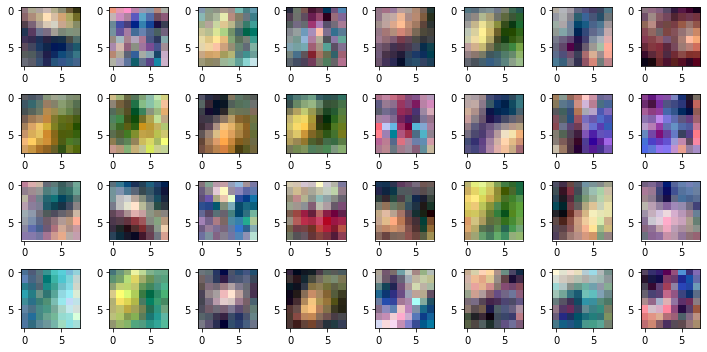

In [138]:
cnn = model.policy.features_extractor.cnn
w0 = cnn[1].weight.cpu().detach().numpy()

f, ax = plt.subplots(4, 8, figsize=(10,5))
ax = ax.reshape(32)
for i in range(32):
    neuron = w0[i, 9:, :, :]
    neuron = (255 * (neuron - np.min(neuron)) / (np.max(neuron) - np.min(neuron))).astype(int)
    ax[i].imshow(neuron.T, cmap='gray')
plt.tight_layout()
plt.savefig("/home/leandro/ml/rl-doom/figures/l0_weights")

(64, 32, 4, 4)


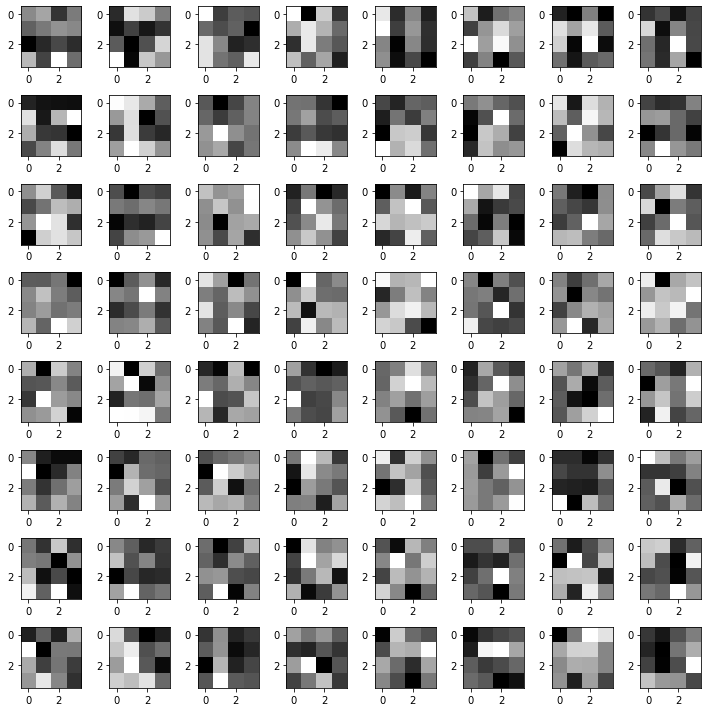

In [36]:
w1 = cnn[4].weight.cpu().detach().numpy()
print(w1.shape)

f, ax = plt.subplots(8, 8, figsize=(10,10))
ax = ax.reshape(64)
for i in range(64):
    neuron = w1[i, 0, :, :]
    neuron = (255 * (neuron - np.min(neuron)) / (np.max(neuron) - np.min(neuron))).astype(int)
    ax[i].imshow(neuron.T, cmap='gray')
plt.tight_layout()

(64, 64, 3, 3)


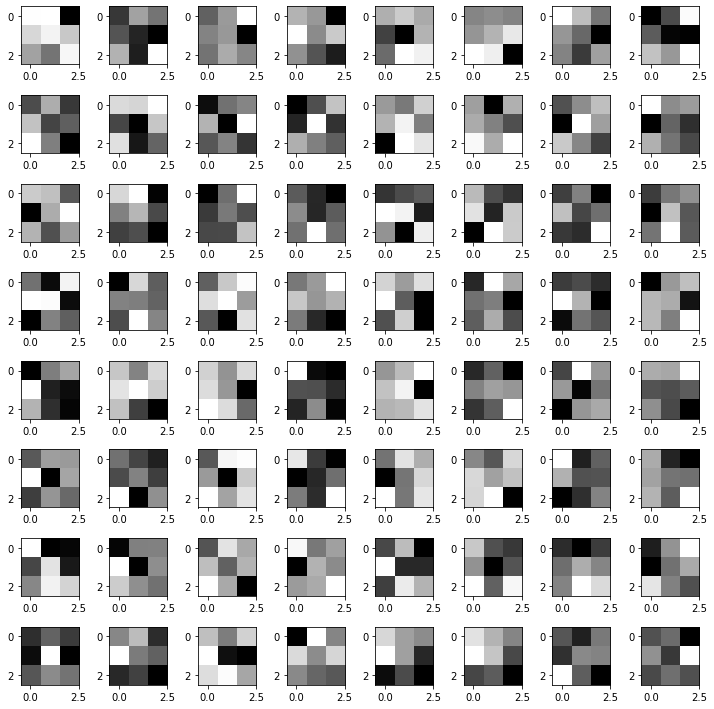

In [37]:
w2 = cnn[7].weight.cpu().detach().numpy()
print(w2.shape)

f, ax = plt.subplots(8, 8, figsize=(10,10))
ax = ax.reshape(64)
for i in range(64):
    neuron = w2[i, 2, :, :]
    neuron = (255 * (neuron - np.min(neuron)) / (np.max(neuron) - np.min(neuron))).astype(int)
    ax[i].imshow(neuron.T, cmap='gray')
plt.tight_layout()

## Layer activation

In [60]:
rolling_buffer_sample = np.zeros((100, 100, 156, 3))
rolling_buffer_sample.shape

(100, 100, 156, 3)

In [105]:
from config import EnvironmentConfig
from stable_baselines3.common.vec_env import VecTransposeImage, VecFrameStack, DummyVecEnv
from environments import utils

env_config = EnvironmentConfig({
    "scenario": "bots_deathmatch_multimaps",
    "type": "multiplayer",
    "args": {
      "maps": ["M", "M_R"],
      "bots": 1,
      "curriculum": False,
      "shaping": True
    },
    "vizdoom_mode": "SPECTATOR",
    "n_parallel": 4,
    "frame_skip": 1,
    "frame_stack": 1,
    "action_combination": True,
    "action_noop": False,
    "obs_width": 320,
    "obs_height": 240,
    "obs_channels": 3,
    "obs_crop": [
      40,
      4,
      0,
      4
    ],
    "obs_resize": [
      0.5,
      0.5
    ]
  })

env = VecTransposeImage(
   VecFrameStack(
        DummyVecEnv([lambda: utils.create_env_with_bots(env_config, eval=True)]),
        1
    )
)

Built action space of size 18 from buttons [<Button.ATTACK: 0>, <Button.MOVE_FORWARD: 13>, <Button.MOVE_LEFT: 11>, <Button.MOVE_RIGHT: 10>, <Button.TURN_RIGHT: 14>, <Button.TURN_LEFT: 15>]
['M']
Logging with ID BD


In [106]:
import time

episodes = 10

for i in range(episodes):
    print(i)
    env.reset()
    while not env.venv.envs[0].game.is_episode_finished():

        env.venv.envs[0].game.advance_action()
        
        time.sleep(1/35.0)
        
        # Save sample in the rolling buffer
        rolling_buffer_sample = np.roll(rolling_buffer_sample, shift=-1, axis=0)
        rolling_buffer_sample[-1, ...] = env.venv.envs[0].game_frame(False) 

env.close()

0
Results:
AGENT: 0
************************
Agent BD frags: 0, deaths: 0, total reward: 0
- frag: +0.0
- damage: +0.0
- ammo: +0.0
- health: +0.0
- armor: +0.0
- distance: +0.0
************************


KeyboardInterrupt: 

In [107]:
np.save('rolling_buffer_sample.npy', rolling_buffer_sample)

In [104]:
env.close()

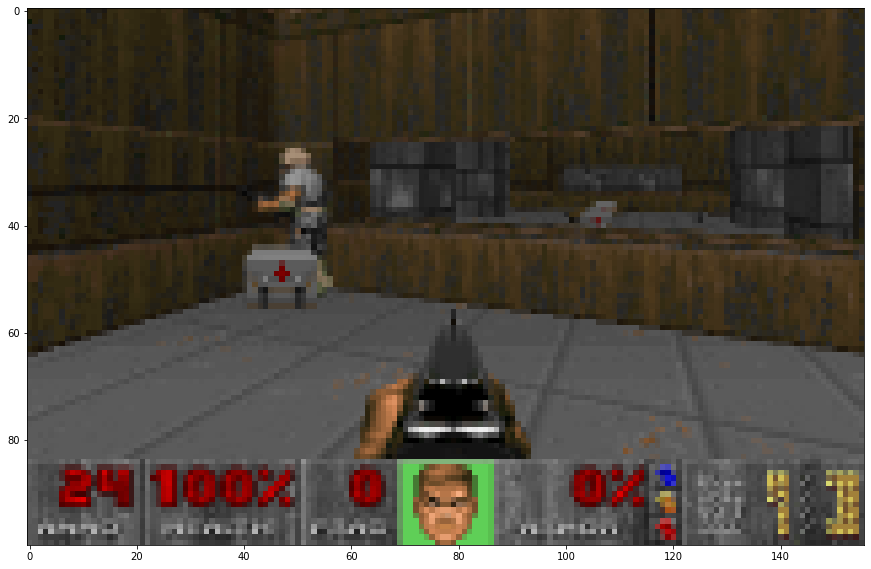

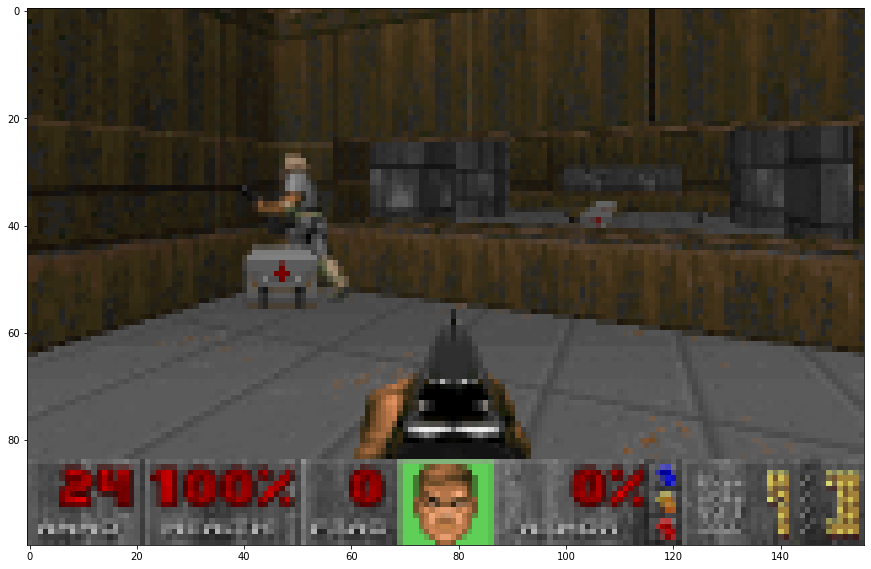

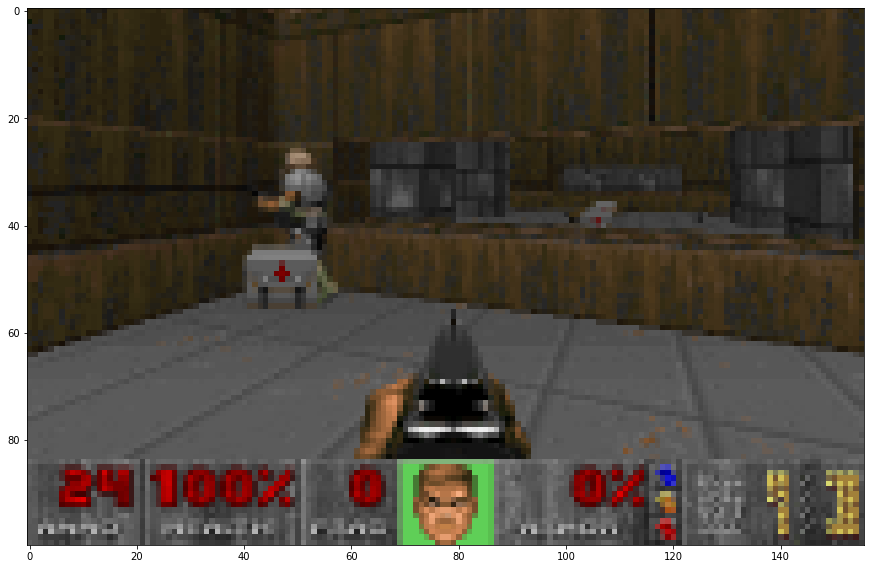

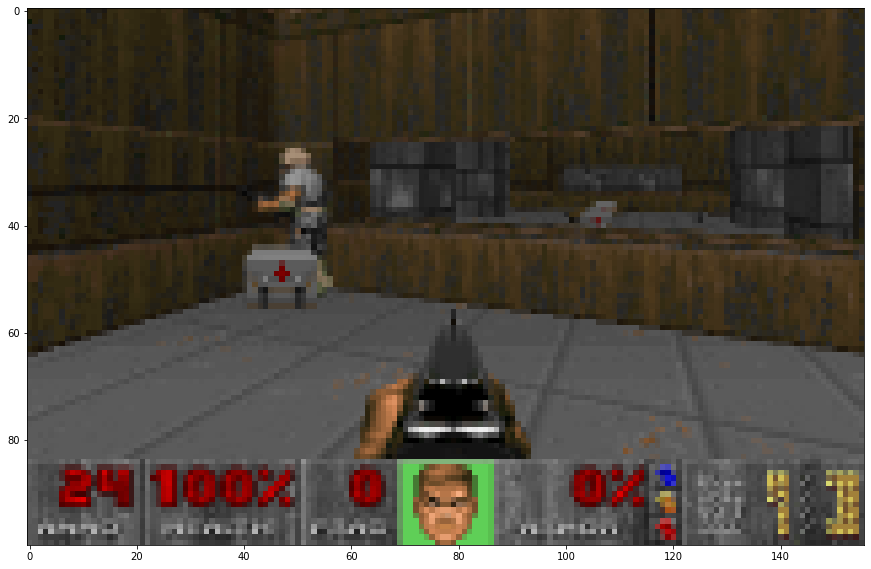

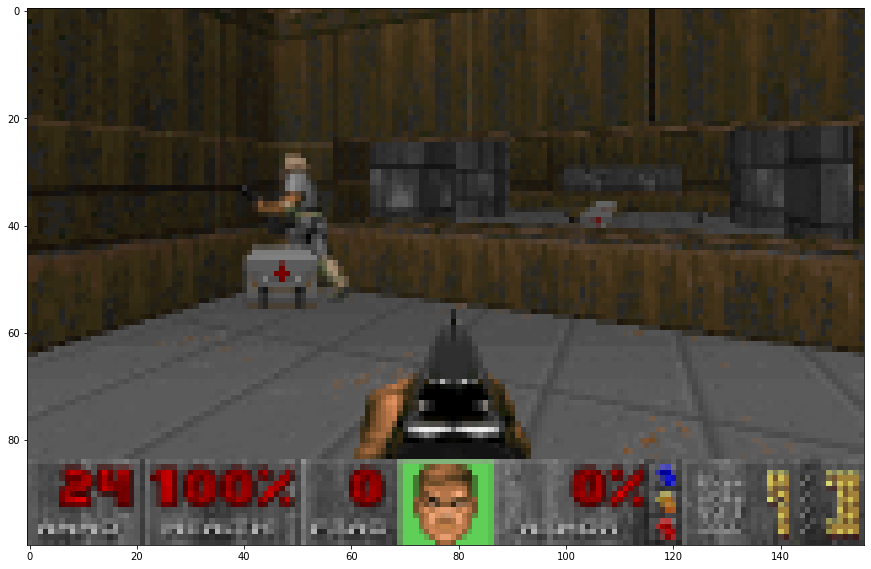

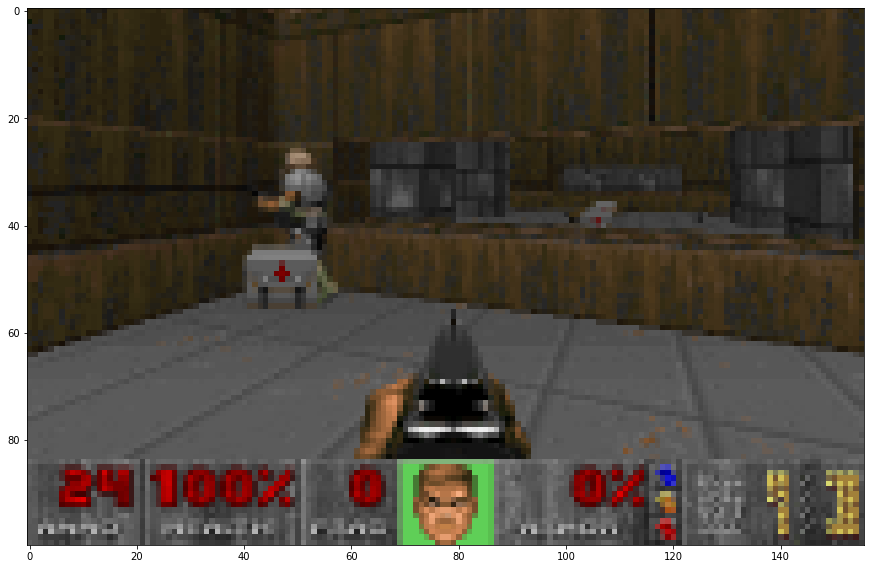

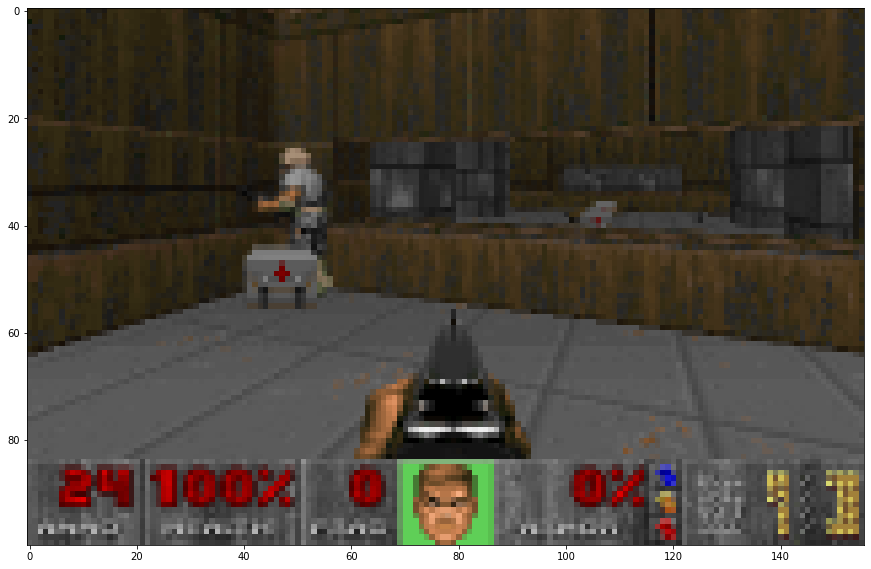

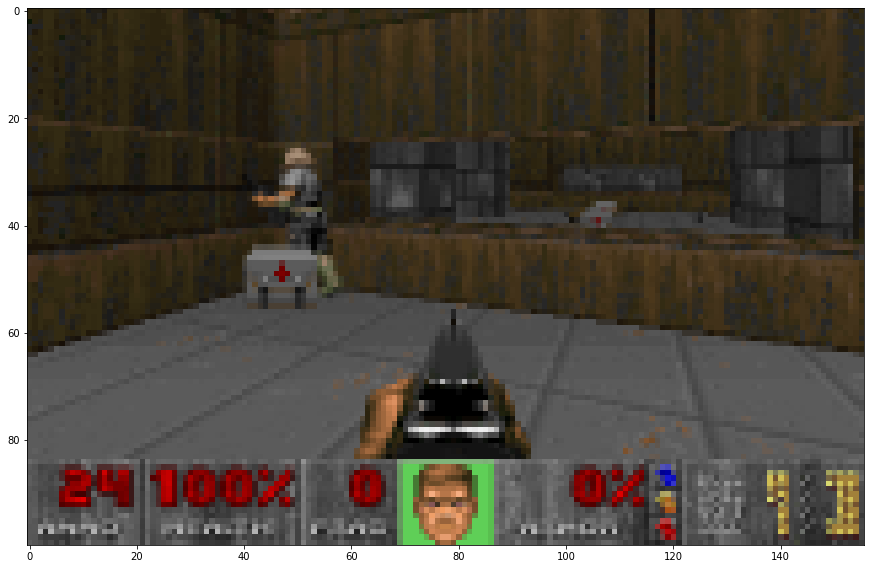

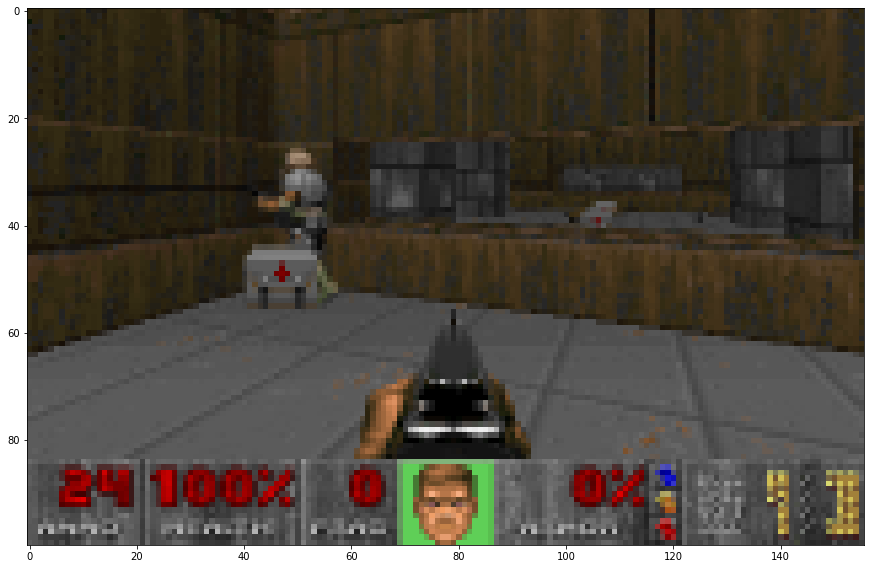

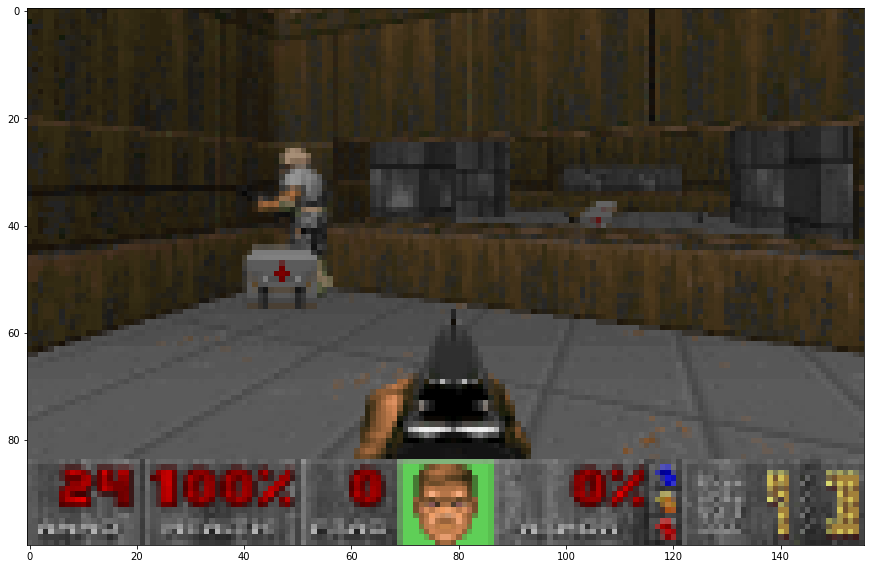

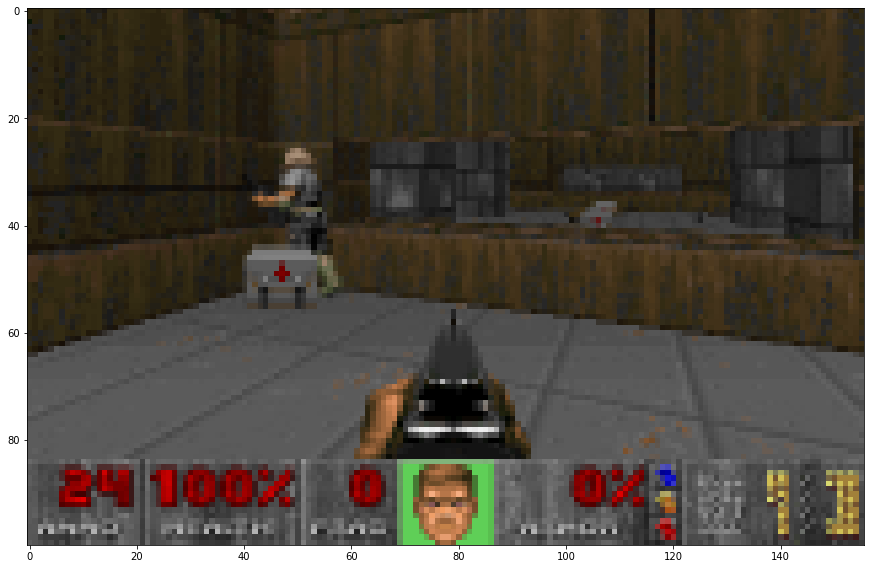

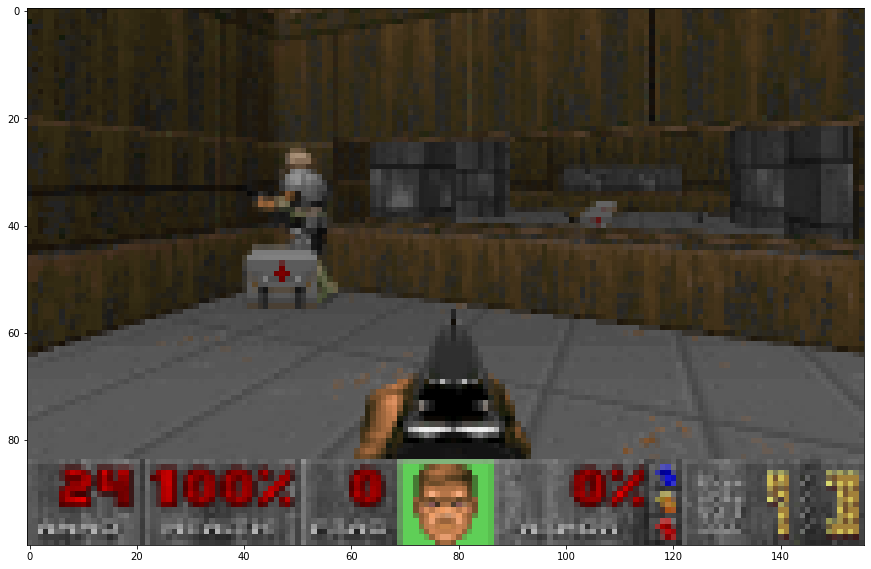

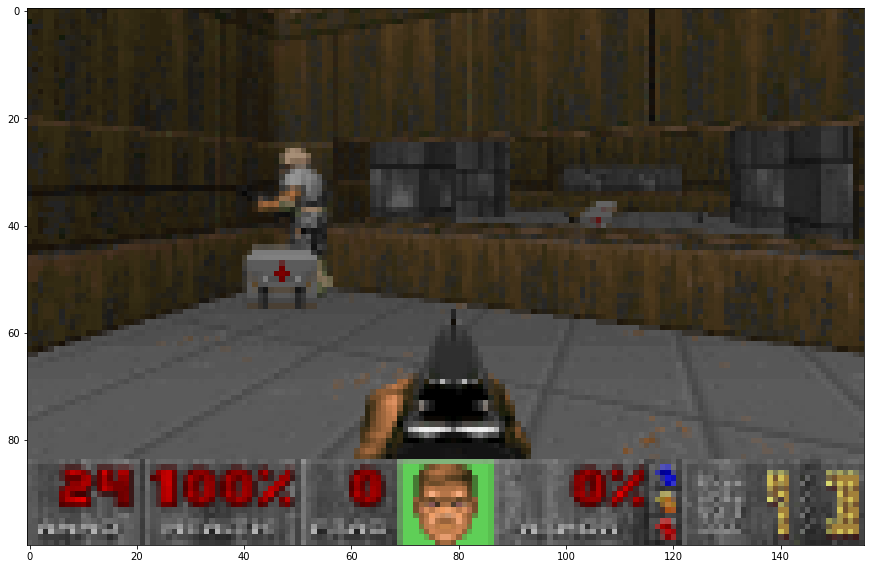

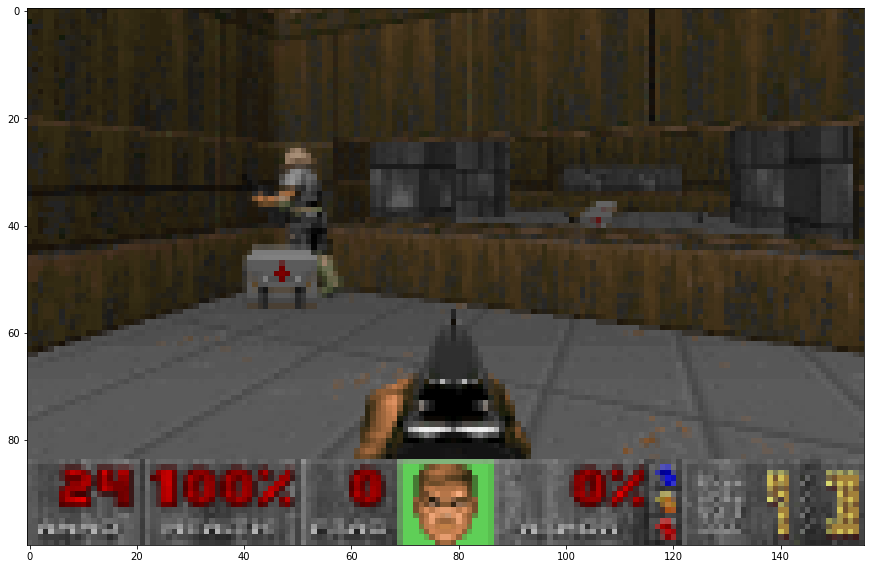

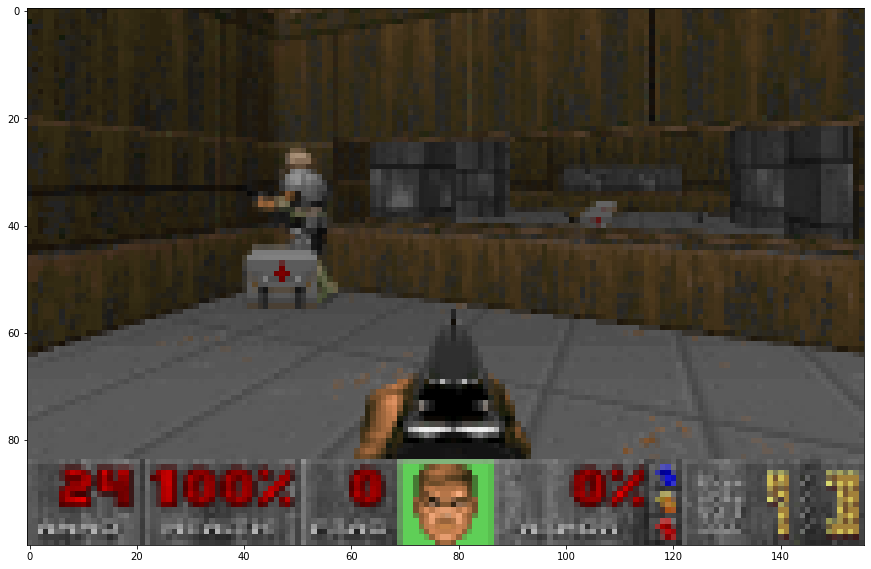

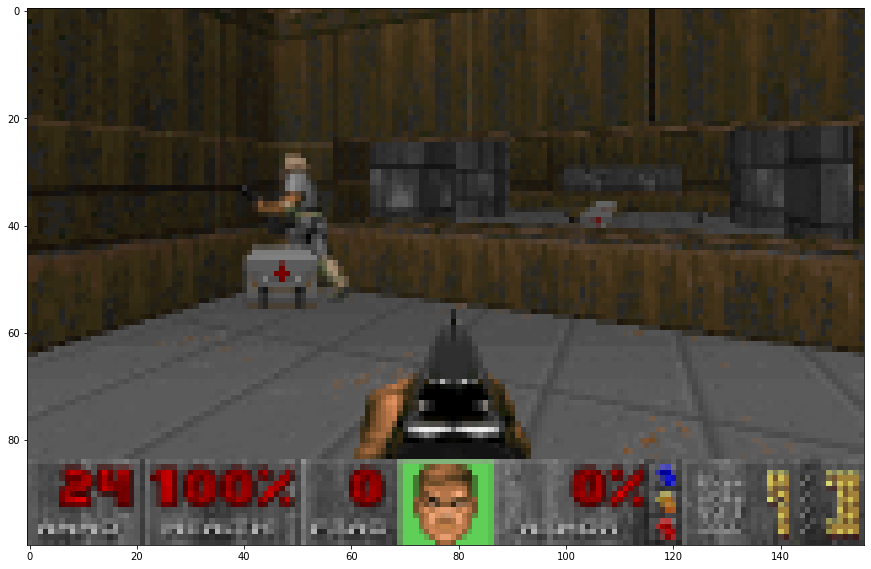

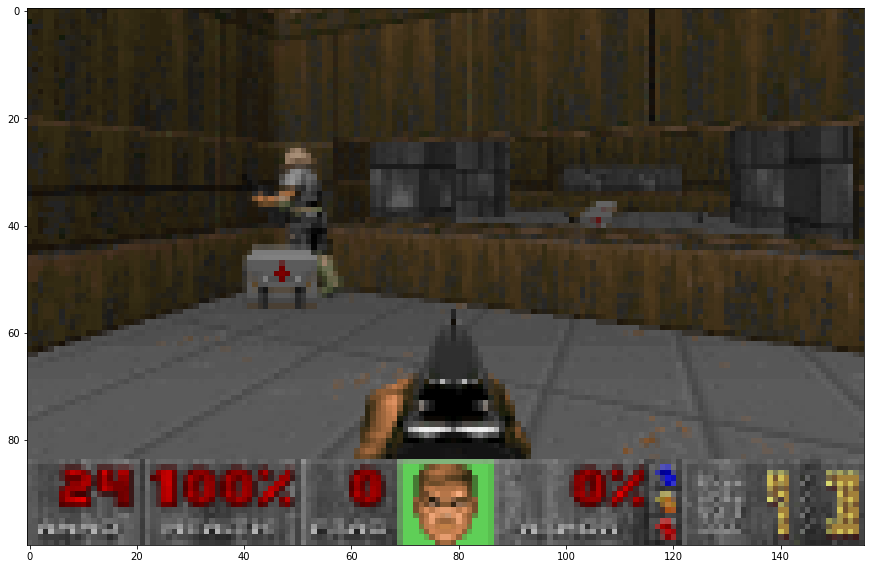

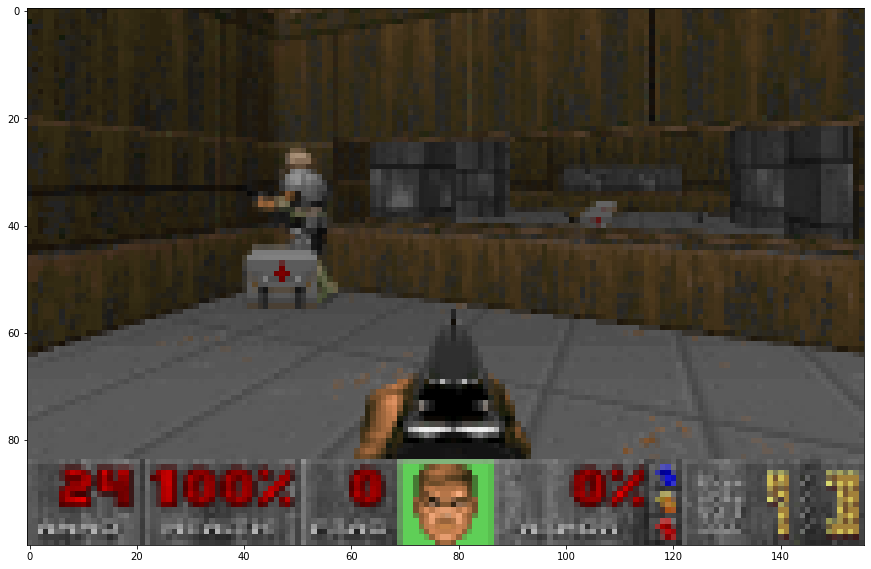

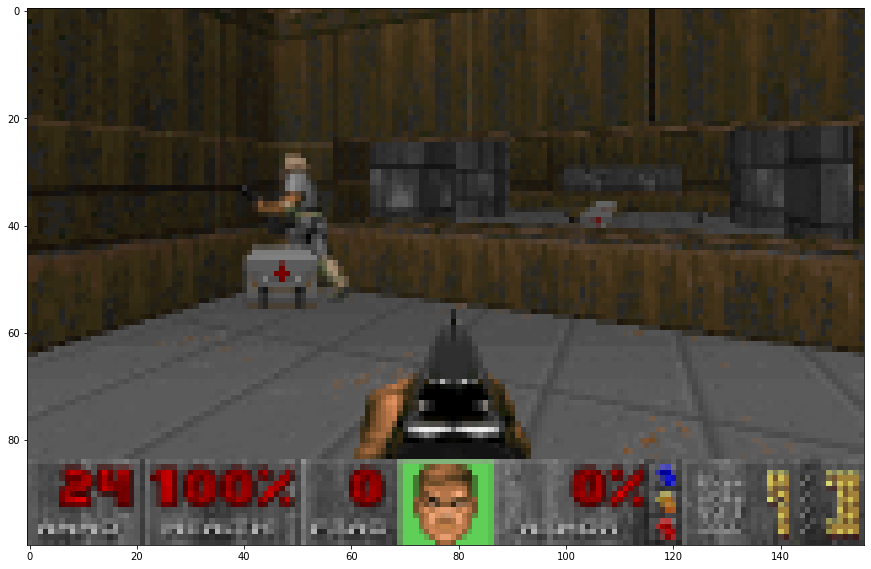

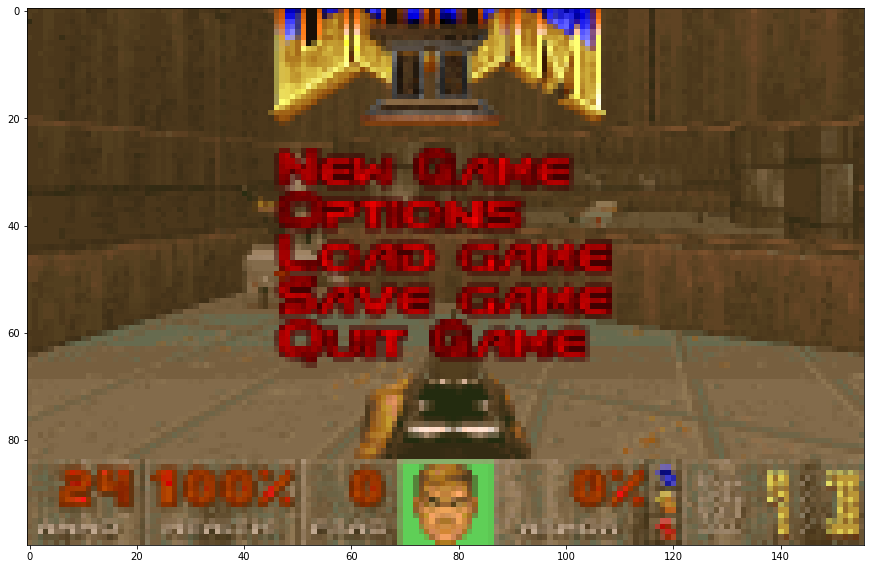

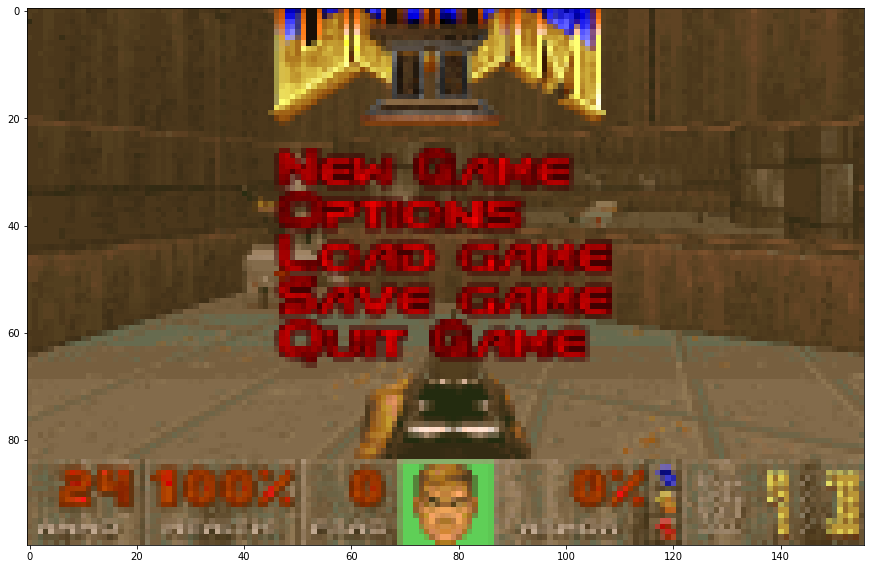

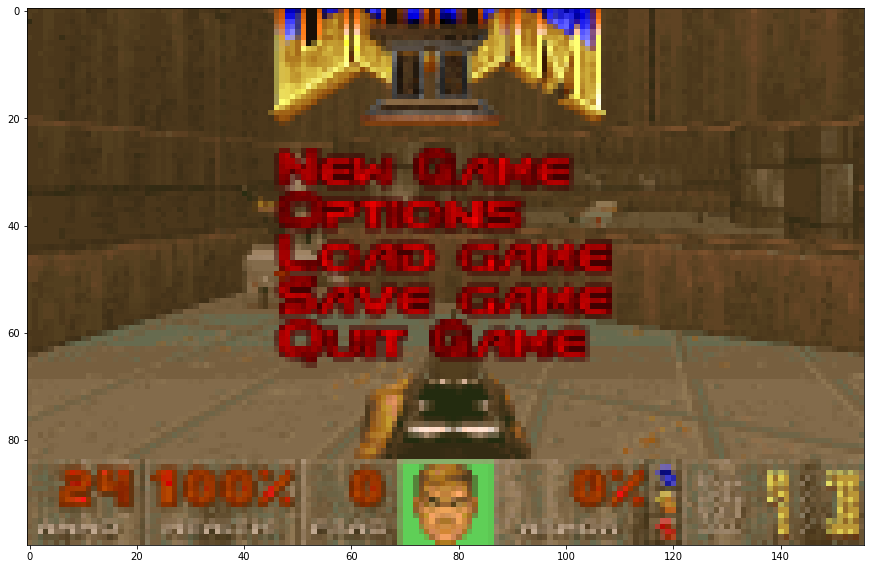

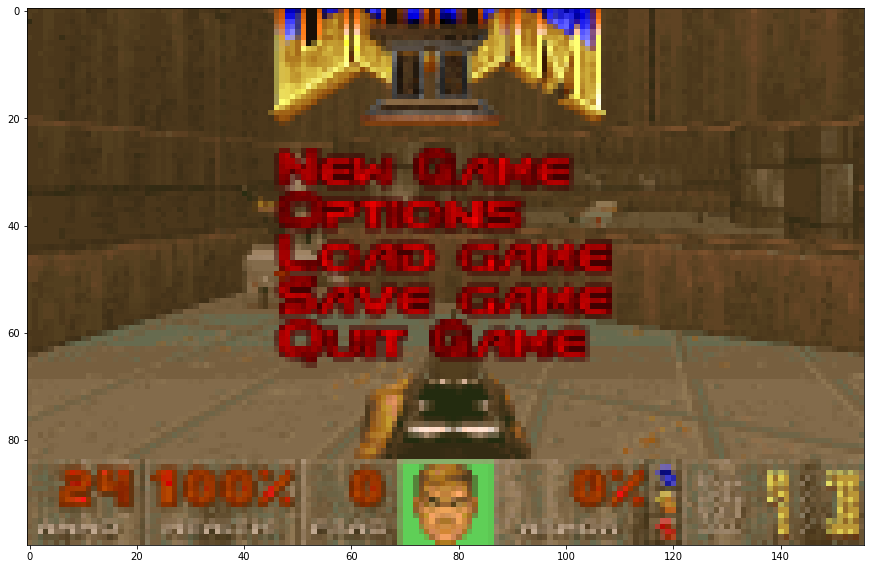

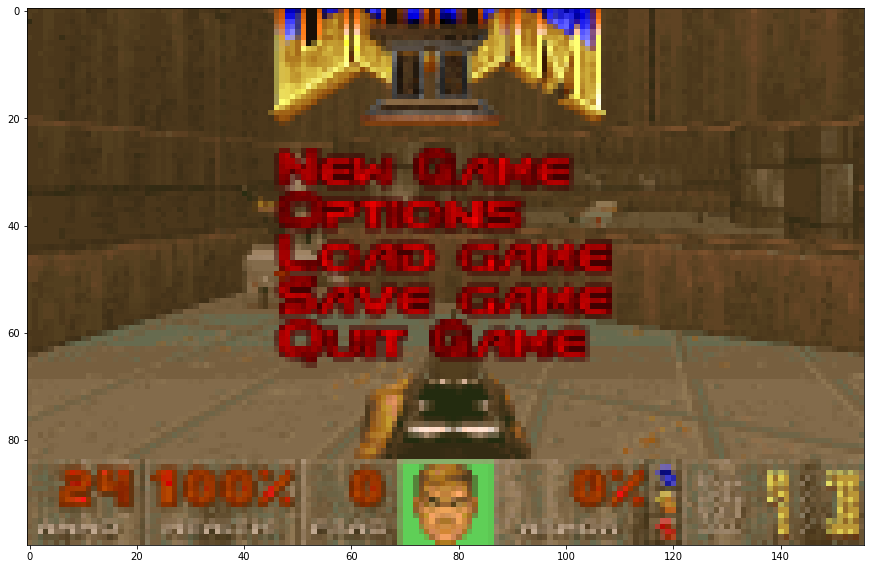

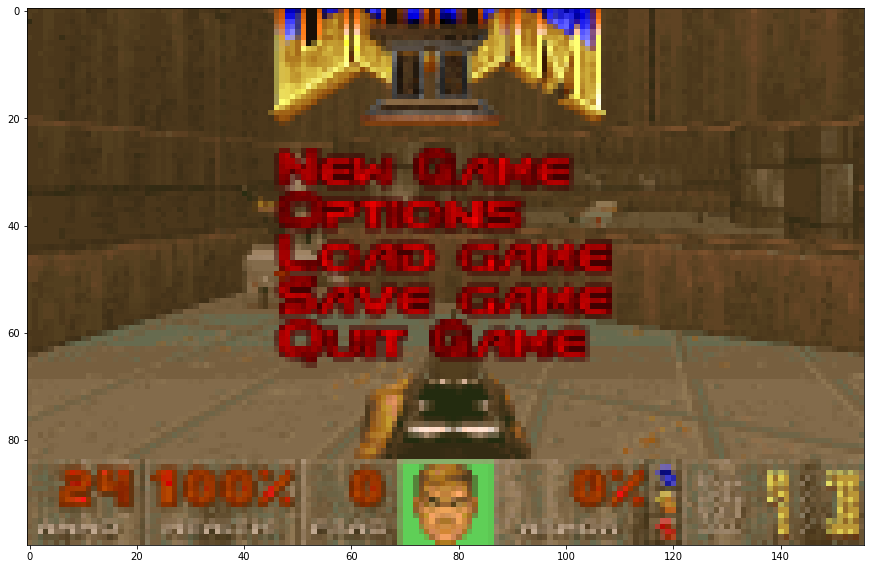

In [108]:
import cv2

for i in range(0,100,4):
    plt.figure(figsize=(15,15))
    plt.imshow(rolling_buffer_sample[i].astype(int))
    plt.show()

In [79]:
from stable_baselines3 import PPO
import torch as th

In [120]:
# Load pre-trained model
model_path = r'/home/leandro/ml/rl-doom/trained_agents/deathmatch/best_model.zip'
agent = PPO.load(model_path)

# Extract the CNN part
cnn = model.policy.features_extractor
cnn = cnn.to(th.device("cpu"))
cnn

CNNFeatureExtractor(
  (cnn): Sequential(
    (0): LayerNorm((3, 100, 156), eps=1e-05, elementwise_affine=True)
    (1): Conv2d(3, 32, kernel_size=(8, 8), stride=(4, 4), bias=False)
    (2): LayerNorm((32, 24, 38), eps=1e-05, elementwise_affine=True)
    (3): LeakyReLU(negative_slope=0.1)
    (4): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (5): LayerNorm((64, 11, 18), eps=1e-05, elementwise_affine=True)
    (6): LeakyReLU(negative_slope=0.1)
    (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (8): LayerNorm((64, 9, 16), eps=1e-05, elementwise_affine=True)
    (9): LeakyReLU(negative_slope=0.1)
    (10): Flatten(start_dim=1, end_dim=-1)
  )
  (linear): Sequential(
    (0): Linear(in_features=9216, out_features=128, bias=False)
    (1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (2): LeakyReLU(negative_slope=0.1)
  )
)

In [121]:
rolling_buffer_sample = np.load('rolling_buffer_sample.npy')

In [122]:
n = 1
frame_skip = 4
frame_stack = 1

# TODO: take in consideration the frameskip in order to match the reality seen by the agent

sample = np.concatenate(rolling_buffer_sample[n : n + frame_stack], axis=-1)
sample.shape

(100, 156, 3)

In [123]:
sample = np.rollaxis(sample, 2, 0)
sample.shape

(3, 100, 156)

In [124]:
import torch as th

data = th.as_tensor(sample[np.newaxis, ...]).float() / 255.0

In [125]:
data.shape

torch.Size([1, 3, 100, 156])

In [126]:
first_activation = cnn.cnn[:2].forward(data).detach().numpy().squeeze()
second_activation = cnn.cnn[:7].forward(data).detach().numpy().squeeze()
third_activation = cnn.cnn[:10].forward(data).detach().numpy().squeeze()

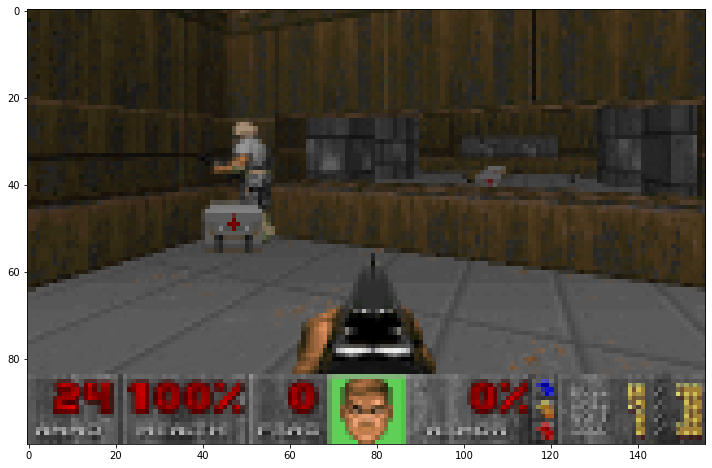

In [127]:
plt.figure(figsize=(14,8))
plt.imshow(np.rollaxis(data.detach().numpy()[0, 0:3, ...], 0,3))

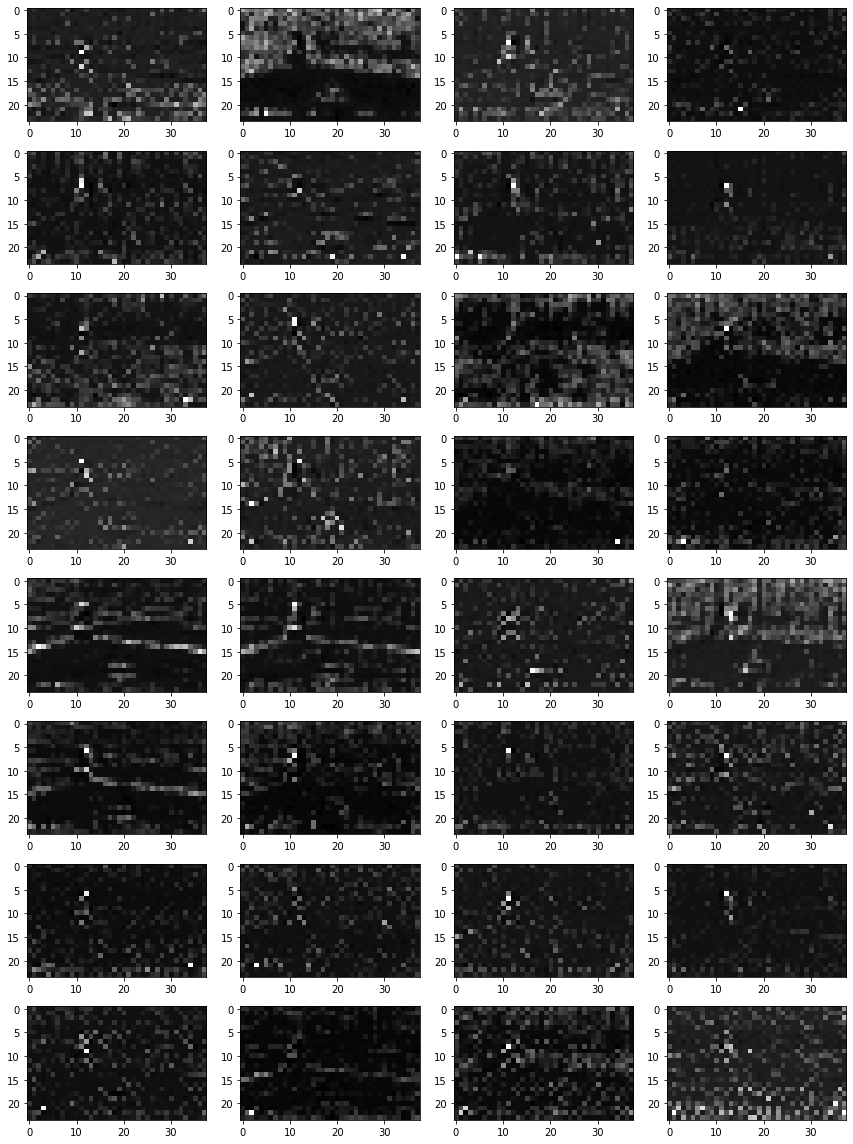

In [128]:
n_plots = first_activation.shape[0]

K = 4
x = 4
y = int(np.ceil(n_plots/4))

f, ax = plt.subplots(y, x, figsize=(x*3,y*2))
ax = ax.reshape(n_plots)
for i in range(n_plots):
    neuron = cnn.cnn[:K].forward(data).detach().numpy().squeeze()[i, :, :]
    ax[i].imshow(neuron, cmap='gray')
plt.tight_layout()
plt.savefig('l1_relu.png')

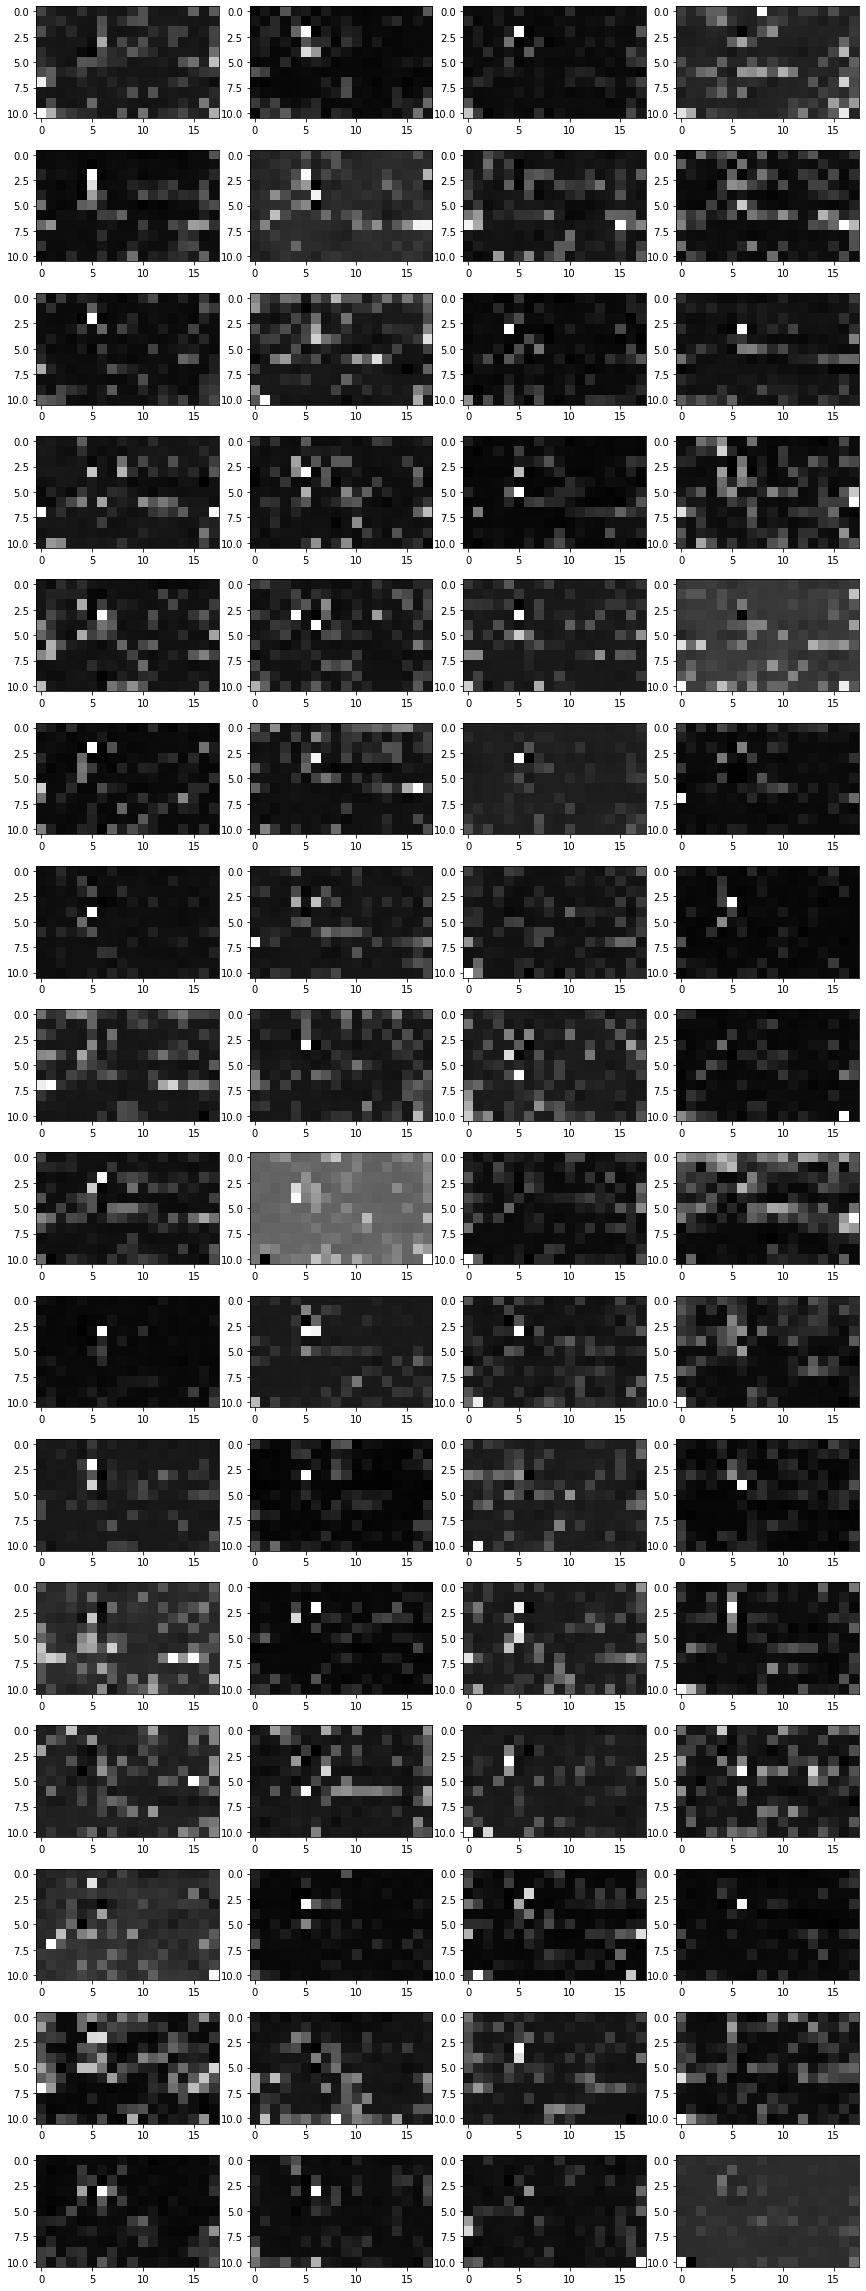

In [129]:
n_plots = second_activation.shape[0]

x = 4
y = int(np.ceil(n_plots/4))

f, ax = plt.subplots(y, x, figsize=(x*3,y*2))
ax = ax.reshape(n_plots)
for i in range(n_plots):
    neuron = second_activation[i, :, :]
    neuron = (255 * (neuron - np.min(neuron)) / (np.max(neuron) - np.min(neuron))).astype(int)
    ax[i].imshow(neuron, cmap='gray')
plt.tight_layout()
plt.savefig('l2_relu.png')

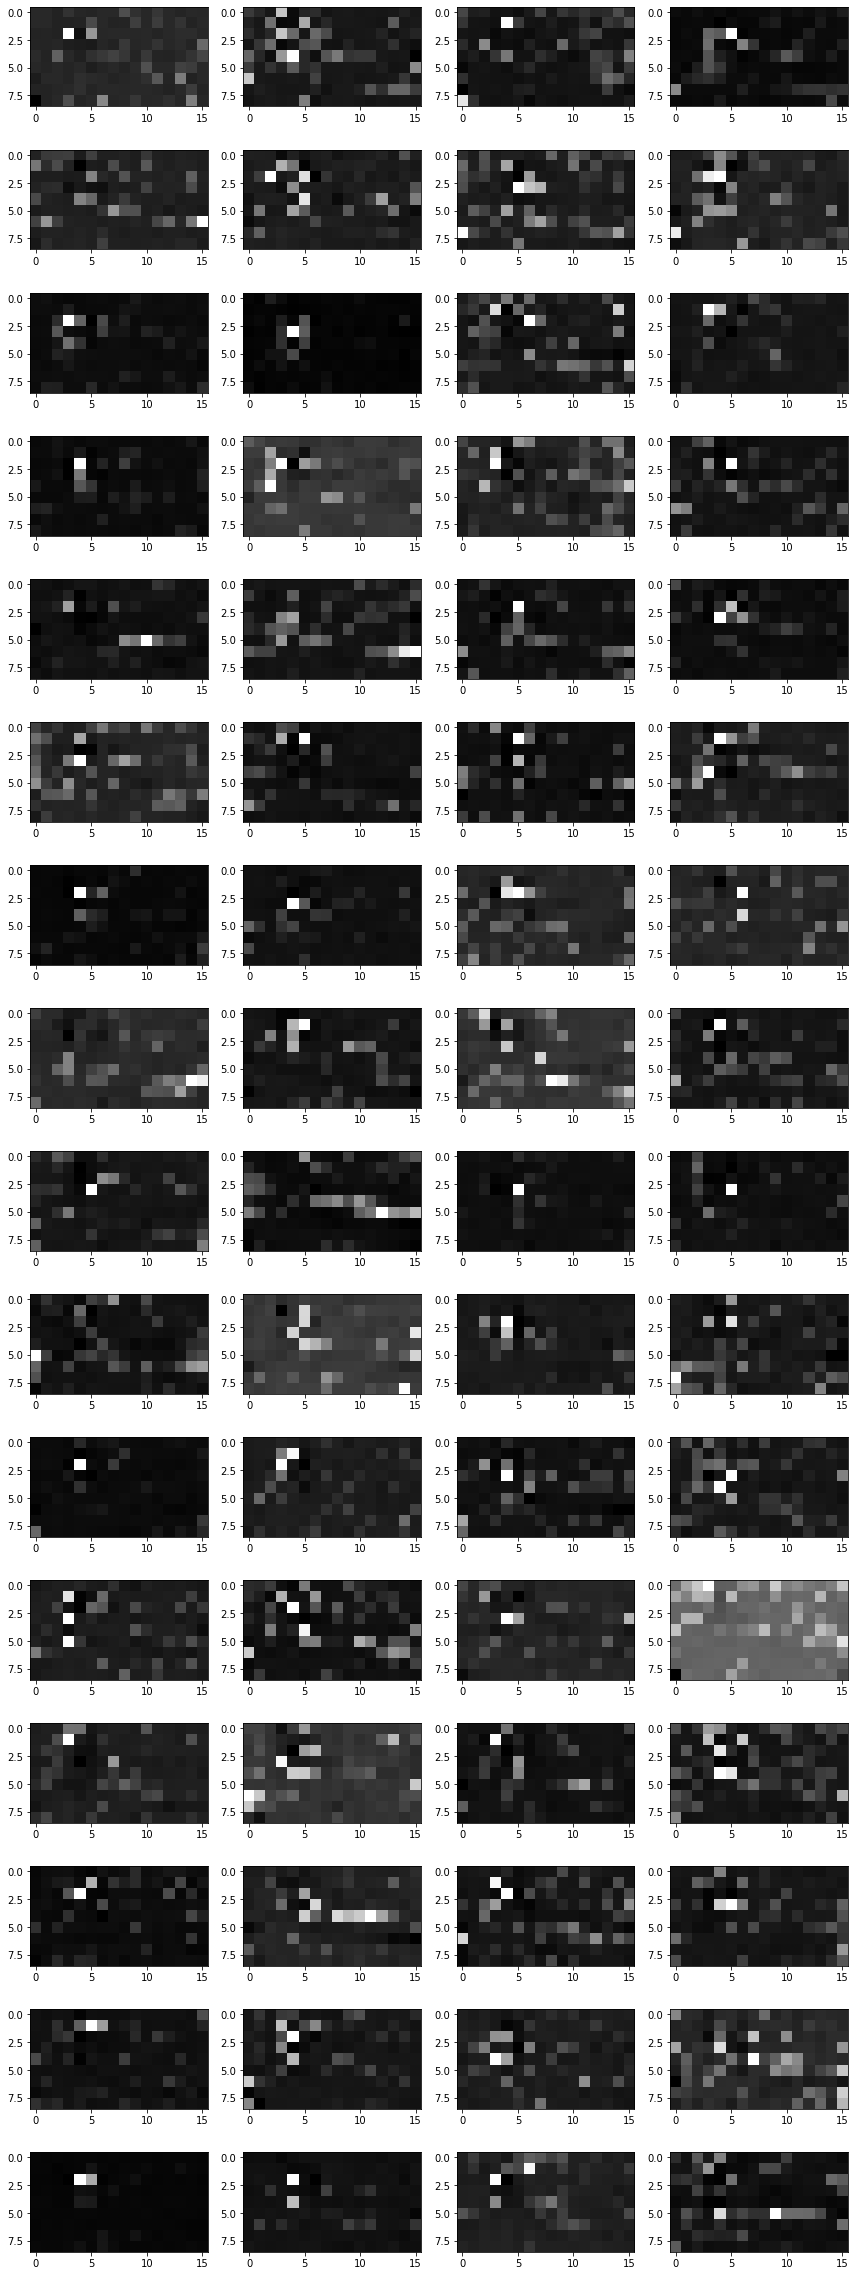

In [130]:
n_plots = third_activation.shape[0]

x = 4
y = int(np.ceil(n_plots/4))

f, ax = plt.subplots(y, x, figsize=(x*3,y*2))
ax = ax.reshape(n_plots)
for i in range(n_plots):
    neuron = third_activation[i, :, :]
    neuron = (255 * (neuron - np.min(neuron)) / (np.max(neuron) - np.min(neuron))).astype(int)
    ax[i].imshow(neuron, cmap='gray')
plt.tight_layout()
plt.savefig('l3_relu.png')